# <center>Polyratings</center>
----------------------------------------------------------------------------------------

# Questions Explored

# Is there a relationship between the students' overall ratings for a professor and the grades that they earned?


# <center>P (Overall rating | Grades, Professor)</center>

# Can we predict the students' overall ratings for a professor given the text of their reviews and the grades that they earned?

#  <center>P (Overall rating | Grades, Text reviews)</center>
----------------------------------------------------------------------------------------

In [1]:
import json
import pandas as pd
from IPython.display import display
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

from ipywidgets import interact, fixed

from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from textblob import TextBlob as tb
from bs4 import BeautifulSoup
import requests

## <center>Load in the Data</center>

In [2]:
path = '/data/primitiveDataType/data.json'

#This code can takes a half minute to run.
def load_data(path):
    
    '''
        Pulls up pd.DataFrames saved in the json file specified by the path. 
        
        Args: 
            path (str): address of json file.
        Returns: 
            professors (pd.DataFrame)
            professor_stats (pd.DataFrame)
            professor_stats_by_grade_list (list of pd.DataFrame objects)
            reviews_by_grade (pd.DataFrame)
    
    
    '''
    jsons = open(path, 'r')
    data = json.load(jsons)
    
    professors, professor_stats, stats_by_grade_list, reviews_by_grade = data
    
    professors = pd.read_json(professors, orient='index') #don't drop index
    professor_stats = pd.read_json(professor_stats, orient='index')# drop index
    
    professor_stats_by_grade_list = []
    
    for p in stats_by_grade_list: 
        professor_stats_by_grade_list.append(pd.read_json(p, orient='index'))

    reviews_by_grade = pd.read_json(data[3], orient='index').reset_index(drop=True)
    
    return professors, professor_stats, professor_stats_by_grade_list, reviews_by_grade

The following line of code takes a few seconds to run.

In [3]:
professors, p_stats, reviews_by_grade_list, reviews_by_grade = load_data(path)

# Professors DataFrame

Holds features for each professor. 
* Name
* Department
* Number of Reporting Evaluations
* Professor ID: unique integers taken from the end professors' pages urls. 

In [4]:
professors.head(10)

,Dept,Name,Reporting Evaluations,prof_id
0,Chemistry and Biochemistry,Christina Abel,32,2073
1,Aerospace Engineering,Kira Aberbromby,6,2390
10,Electrical Engineering,Samuel Agbo,54,4
100,English,Jacquelyn Belknap,25,2928
1000,English,Erin Martin-Elston,45,1927
1001,Chemistry and Biochemistry,Andres Martinez,14,2799
1002,Biological Sciences,Nathaniel Martinez,5,3907
1003,Modern Languages and Literatures,William Martinez,22,411
1004,English,Steven Marx,37,412
1005,Mechanical Engineering,Tom Mase,9,1846


# Professor Aggregate Statistics DataFrame
Holds aggregate statistics about the reviews for each professor.
* Mean
* Median 
* Mode
* Category (Overall Rating, Presents Material Clearly, Recognizes Student Difficulties)
* Standard deviation
* Professor ID 

In [5]:
p_stats.head(6)

,mean,median,mode,prof_id,rating_type,std_dev
0,3.563,4,4,2073,Overall Rating,0.556
1,3.594,4,4,2073,Presents Material Clearly,0.551
10,3.941,0,4,1,Presents Material Clearly,0.235
100,2.700,3,4,3500,Presents Material Clearly,1.418
1000,1.000,1,1,146,Presents Material Clearly,0.791
1001,0.625,1,0,146,Recognizes Student Difficulties,0.781


# Reviews by Grade (Aggregate) DataFrame
Holds aggregate statistics of reviews grouped by the reviewers' grades earned in the class. 

* Category (Overall Rating, Presents Material Clearly, Recognizes Student Difficulties)
* Professor ID 

* A: mean rating by students with an A
* B: mean rating by students with a B
* C: mean rating by students with a C
* D: mean rating by students with a D
* F: mean rating by students with an F
* Credit: mean rating by students receiving credit
* No Credit: mean rating by students not receiving credit
* N/A: mean rating by students without knowledge of their grade at time of review

In [6]:
display(reviews_by_grade_list[0])
display(reviews_by_grade_list[1])

,A,B,C,Credit,D,F,N/A,No Credit,prof_id
Overall Rating,3.769,3.222,3.75,NaN,3,NaN,3,NaN,2073
Presents Material Clearly,3.769,3.222,3.75,NaN,3,NaN,4,NaN,2073
Recognizes Student Difficulties,3.692,3.222,3.75,NaN,4,NaN,3,NaN,2073
Reporting Evaluations,13.000,9.000,8.00,NaN,1,NaN,1,NaN,2073


,A,B,C,Credit,D,F,N/A,No Credit,prof_id
Overall Rating,4,4,NaN,NaN,4,NaN,1.5,NaN,2390
Presents Material Clearly,4,3,NaN,NaN,4,NaN,1.5,NaN,2390
Recognizes Student Difficulties,4,4,NaN,NaN,4,NaN,2.0,NaN,2390
Reporting Evaluations,2,1,NaN,NaN,1,NaN,2.0,NaN,2390


# Reviews by Grade (Aggregate) DataFrame
Holds aggregate statistics of reviews grouped by the reviewers' grades earned in the class. 

* Course
* Grade: received by reviewer (A, B, C, D, F, Credit, No Credit, N/A) for the class
* Category (Overall Rating, Presents Material Clearly, Recognizes Student Difficulties)
* Reporting Evaluations: Number of reviews for that professor by students receiving that grade
* Year: year level of reviewer (Freshman, Sophomore, Junior, Senior, 5th Year Senior, Graduate Student)
* Professor ID 
* Review ID: unique integer scraped from HTML of Polyratings

In [7]:
display(reviews_by_grade.head(4))

,Course,Grade,Overall Rating,Presents Material Clearly,Recognizes Student Difficulties,Reporting Evaluations,Review,Year,prof_id,review_id
0,CHEM 124,A,3.769,3.769,3.692,13,"To do well in Abel's class, the key is practic...",Freshman,2073,34359
1,CHEM 127,A,3.769,3.769,3.692,13,Great professor! I learned a lot in her class....,Freshman,2073,34176
2,CHEM 124,A,3.769,3.769,3.692,13,Dr. Abel is a great chem prof. I would recomme...,Freshman,2073,31660
3,PHIL 126,B,2.800,3.143,2.400,35,Abney's first day of class was a bitter one. H...,Junior,2,11083


----------------------------------------------------------------------------------------

# Which Rating Should We Predict? 
We can choose from 'Overall Rating', 'Presents Material Clearly', and 'Recognizes Student Difficulties.' Does it matter which one we choose?

See how the scatterplots below display how the categories are strongly positively, linearly correlated.

## Conclusion: Let's predict the 'Overall Rating.' 
We have reasonable assurance that our predictions will correlate with the other two categories as well.

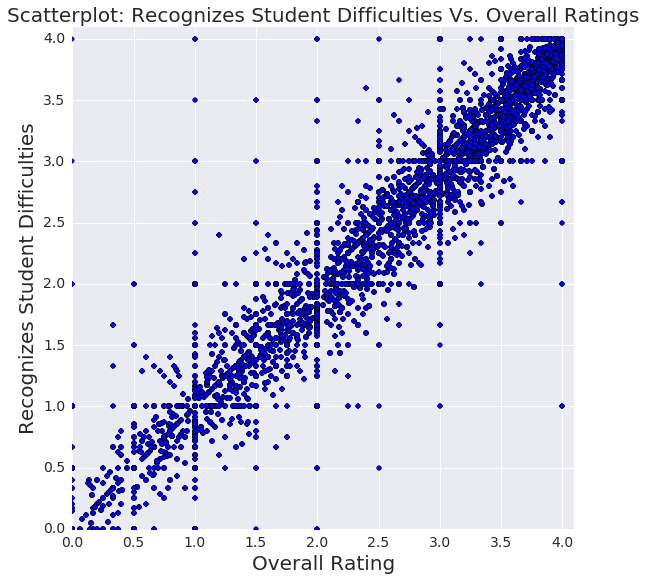

In [8]:
f = plt.figure()
f.set_size_inches(9, 9, forward=True)

plt.xlim([0, 4.1])
plt.ylim([0, 4.1])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


plt.scatter(reviews_by_grade['Overall Rating'], \
            reviews_by_grade['Recognizes Student Difficulties'])
plt.xlabel('Overall Rating', fontsize='20')
plt.ylabel('Recognizes Student Difficulties', fontsize='20')
plt.title('Scatterplot: Recognizes Student Difficulties Vs. Overall Ratings', \
           fontsize='20')

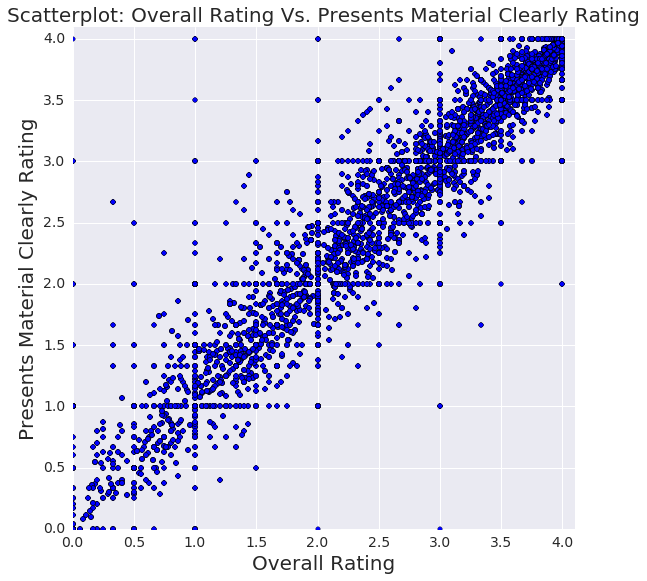

In [9]:
f2 = plt.figure()
f2.set_size_inches(9, 9, forward=True)

plt.xlim([0, 4.1])
plt.ylim([0, 4.1])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.scatter(reviews_by_grade['Overall Rating'], \
            reviews_by_grade['Presents Material Clearly'])
plt.xlabel('Overall Rating', fontsize='20')
plt.ylabel('Presents Material Clearly Rating', fontsize='20')
plt.title('Scatterplot: Overall Rating Vs. Presents Material Clearly Rating', \
           fontsize='20')

----------------------------------------------------------------------------------------

# Plot P (Overall rating | Grades)

Grades is an ordinal variable, so it's easier to see its relationship with Overall Ratings in a plot; there is an intrinsic ordering between grades. 

In contrast, Professor ID is nominal, so it's not as easy to see its relationship with Overall Ratings in a plot; there is no intrinsic ordering between professors.

In [10]:
order=['A', 'B', 'C', 'D', 'F', 'No Credit', 'Credit', 'N/A']

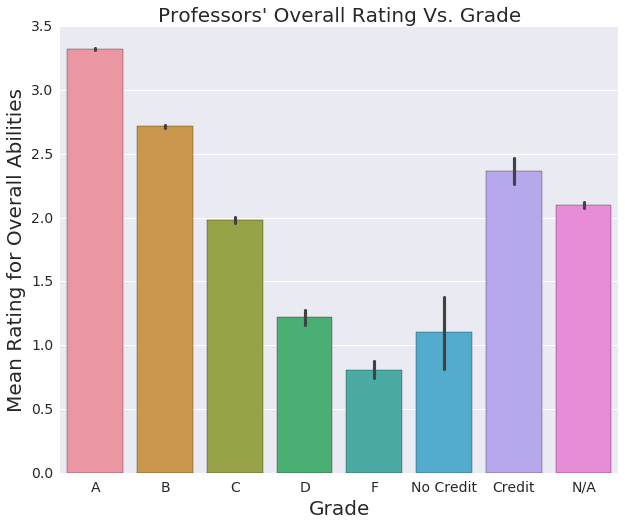

In [11]:
f3 = plt.figure()
f3.set_size_inches(10, 8, forward=True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

sns.barplot(reviews_by_grade['Grade'], reviews_by_grade['Overall Rating'], order=order)
plt.xlabel('Grade', fontsize='20')
plt.ylabel('Mean Rating for Overall Abilities', fontsize='20')
plt.title('Professors\' Overall Rating Vs. Grade', fontsize='20')

## Students earning higher grades are _consistently_ giving higher 'Overall Ratings' to their professors. 

## We should be able to take advantage of this pattern and make some predictions with machine learning.

----------------------------------------------------------------------------------------

In [12]:
def load_df(path):
    '''
    Loads a single pd.DataFrame from a specified json path.
    Args: path (str): address of the JSON file
    Returns: a DataFrame
    '''
    jsons = open(path, 'r')
    data = json.load(jsons)
    df = pd.read_json(data, orient='index') #don't drop index
    return df

# <center>Machine Learning Modeling with Linear Regression</center>

## Compute TextBlob's Sentiment Analysis on reviews. 
Note: Loading in the reviews_by_grades DataFrame that included Sentiment Analysis via JSON from the Machine Learning Notebook was causing problems with the $r^2$ value.

In [13]:
def process_review(review_text): 
    review = tb(review_text)
    sentiment = review.sentiment
    return [sentiment.polarity, sentiment.subjectivity]

p, s = process_review(reviews_by_grade['Review'][0])
p, s

(0.17954545454545454, 0.5446969696969698)

The following code takes a minute to run.

In [14]:
reviews_by_sentiment = reviews_by_grade
reviews_by_sentiment['Sentiment'] = reviews_by_sentiment['Review'].apply(process_review)
reviews_by_sentiment['Polarity'] = reviews_by_sentiment['Sentiment'].map(lambda x: x[0])
reviews_by_sentiment['Subjectivity'] = reviews_by_sentiment['Sentiment'].map(lambda x: x[1])
display(reviews_by_sentiment.head(1))

,Course,Grade,Overall Rating,Presents Material Clearly,Recognizes Student Difficulties,Reporting Evaluations,Review,Year,prof_id,review_id,Sentiment,Polarity,Subjectivity
0,CHEM 124,A,3.769,3.769,3.692,13,"To do well in Abel's class, the key is practic...",Freshman,2073,34359,"[0.17954545454545454, 0.5446969696969698]",0.179545,0.544697


In [15]:
display(reviews_by_sentiment.head())

,Course,Grade,Overall Rating,Presents Material Clearly,Recognizes Student Difficulties,Reporting Evaluations,Review,Year,prof_id,review_id,Sentiment,Polarity,Subjectivity
0,CHEM 124,A,3.769,3.769,3.692,13,"To do well in Abel's class, the key is practic...",Freshman,2073,34359,"[0.17954545454545454, 0.5446969696969698]",0.179545,0.544697
1,CHEM 127,A,3.769,3.769,3.692,13,Great professor! I learned a lot in her class....,Freshman,2073,34176,"[0.4375, 0.6267857142857143]",0.437500,0.626786
2,CHEM 124,A,3.769,3.769,3.692,13,Dr. Abel is a great chem prof. I would recomme...,Freshman,2073,31660,"[0.3666666666666667, 0.76]",0.366667,0.760000
3,PHIL 126,B,2.800,3.143,2.400,35,Abney's first day of class was a bitter one. H...,Junior,2,11083,"[0.10714285714285715, 0.6808862433862434]",0.107143,0.680886
4,BUS 215,B,3.400,3.300,3.400,10,Jim goes over homework in detail every day. Th...,Sophomore,12,9584,"[-0.0869140625, 0.525]",-0.086914,0.525000


## Examples of how well Sentiment Analysis works.

In [16]:
print('Review: ', reviews_by_sentiment['Review'][50])
print('Polarity: ', reviews_by_sentiment['Polarity'].values[50])
print('Subjectivity: ', reviews_by_sentiment['Subjectivity'].values[50])
print('\nProposed Explanation: Sentiment analysis is inaccurate because of the language '
      'use does not correspond with meaning.')
print('\n-------------------------------------------------------------------------------')
print('Review: ', reviews_by_sentiment['Review'][10012])
print('Polarity: ', reviews_by_sentiment['Polarity'].values[10012])
print('Subjectivity: ', reviews_by_sentiment['Subjectivity'].values[10012])
print('\nProposed Explanation: Sentiment analysis is accurate because the language ', 
      'use corresponds with meaning.')
print('\n-------------------------------------------------------------------------------')
print('Review: ', reviews_by_sentiment['Review'][14])
print('Polarity: ', reviews_by_sentiment['Polarity'].values[14])
print('Subjectivity: ', reviews_by_sentiment['Subjectivity'].values[14])
print('\nProposed Explanation: Crying is a good thing?...')

Review:  Dr. Daly is a great teacher who clearly explains everything and is a very fair grader.  He doesn't collect homework, but offers help and suggested problems if it is needed.  I found his class challenging but not impossible.  He tests on what is covered in class, and you won't need to learn anything from the book.
Polarity:  0.457222222222
Subjectivity:  0.688888888889

Proposed Explanation: Sentiment analysis is inaccurate because of the language use does not correspond with meaning.

-------------------------------------------------------------------------------
Review:  I am surprised so many people are ragging on Hampsey on PolyRatings. I loved the guy! Hardly ANY homework (your grade is one midterm, one final, and one 4-5 page essay) and as long as you pay attention in class you are good to go for the tests. Plus, he has interesting things to say about human nature and how it is reflected in different cultures. He drags politics into everything we talk about, which gets ir

## Select Relevant Columns, with dummy values for grades.

In [17]:
reviews_by_sentiment.dropna(inplace=True)
X = pd.concat([reviews_by_sentiment['Grade'], reviews_by_sentiment['prof_id'], \
              reviews_by_sentiment['Polarity'], reviews_by_sentiment['Subjectivity']], axis=1)
X = pd.concat([X, pd.get_dummies(X['Grade']).dropna()], axis=1)
X.drop(['Grade', 'N/A', 'Credit', 'No Credit', 'Subjectivity'], axis=1, inplace=True)
display(X.head())

assert len(X.columns) == 7
assert X.isnull().any().any() == False
assert np.isinf(X.any().any()) == False
np.isfinite(X.all())

#Set y to the column we want to predict.
y = reviews_by_grade['Overall Rating']
y.dropna(inplace=True)

assert type(y) == pd.Series
assert type(y.values[0]) == np.float64
assert np.nan not in y.values
assert np.isfinite(y.all()) == True

,prof_id,Polarity,A,B,C,D,F
0,2073,0.179545,1,0,0,0,0
1,2073,0.437500,1,0,0,0,0
2,2073,0.366667,1,0,0,0,0
3,2,0.107143,0,1,0,0,0
4,12,-0.086914,0,1,0,0,0


### Above are the features we are using to predict the 'Overall Rating' values below.
Features: [Grade earned and Sentiment Analysis of Review Text]

In [18]:
y.head()

0    3.769
1    3.769
2    3.769
3    2.800
4    3.400
Name: Overall Rating, dtype: float64

## Test -- Train -- Split

In [19]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.10, random_state=0)

print('Train set shapes: ', Xtrain.shape, ytrain.shape)
print('Test set shapes: ', Xtest.shape, ytest.shape)

Train set shapes:  (48833, 7) (48833,)
Test set shapes:  (5426, 7) (5426,)


In [20]:
assert Xtrain.shape[0] == ytrain.shape[0]
assert Xtest.shape[0] == ytest.shape[0]
assert type(ytrain.values[0]) == np.float64
assert type(ytest.values[0]) == np.float64
assert np.nan not in ytrain.unique() 
assert np.isfinite(Xtrain.all().all()) == True
Xtrain = Xtrain.round(2)
assert ytrain.dtype == np.float64
assert np.nan not in ytrain.unique()

# Linear Regression

#### Why Linear Regression? 
Linear Regression alows us to pridict a values that are continuous, unlike Random Forests, and other models that predict discrete values.

* __Construct a model__
* __Fit the model__ to the data
* __Predict__
* Rather than assessing the score, let's __compute the $r^2$ values__ to find the difference between predicted y-values and y-test values.

In [21]:
# Instantiate a model
model_lr = LinearRegression()

#Fit the model to the Training Set
model_lr.fit(Xtrain, ytrain)

#Make the prediction
prediction_lr = model_lr.predict(Xtest)
prediction_lr

array([ 3.34118105,  3.350047  ,  2.40238737, ...,  2.72610533,
        2.87115234,  2.25747221])

## $r^2$ Score

In [22]:
#Get an $r^2$ Score
r2_score(prediction_lr, ytest)

-0.44486297343758308

## Compute 95% and 80% Percentiles of $r^2$

In [23]:
def compute_percentile(q1, q3): 
    '''
    Computes + Plots the values of the percentiles for the ytest 
    subtracted from prediction_lr. 
    
    Args: q1 (float): percentile
          q3 (float): percentile
    Returns: 
        None:
    '''
    
    difference = prediction_lr - ytest
    percentile = np.percentile(difference, (q1, q3))
    print('Percentiles: ', (percentile[0], percentile[1]))
    
    f = plt.figure()
    f.set_size_inches(10, 10, forward=True)
    sns.distplot(prediction_lr - ytest)

    plt.xlabel('Difference = Linear Regression Prediction - ytest', fontsize='20')
    plt.ylabel('Occurrences', fontsize='20')
    plt.title('How Far Off is the Model from the Test Values?', fontsize='20')
#     eightieth_percentile = [-0.926, 1.095]
#     ninety_five_percentile = [-1.482, 1.720]
    
    plt.vlines(percentile, 0, .6, color='b',linestyles='solid')
    plt.show()

Percentiles:  (-0.92576422940565384, 1.0954422212966741)


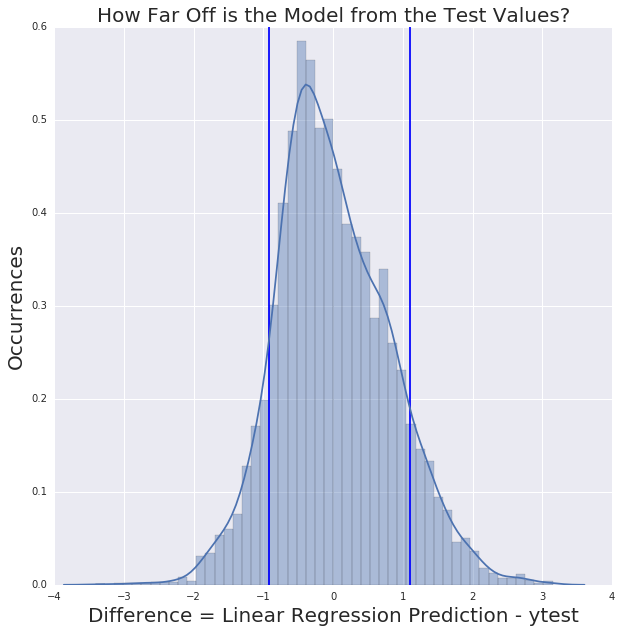

In [25]:
interact(compute_percentile, q1=(0, 15, .5), q3=(85, 100, .5), __manual=True);

# Assess Machine Learning Results by $r^2$

### 80th Percentile: Set q1 to 10 and q3 to 90
The model's prediction is within 1.0 of the test values at the 80th percentile. Differences between the predicted and test values range from: [-0.926, 1.096]

### 95th Percentile: Set q1 to 2.5 and q3 to 97.5
The 95th percentile is shown by the vertical lines. Differences between the predicted and test values range from: [-1.482, 1.720]

This -0.448 $r^2$ score that includes Sentiment Analysis is huge an improvement of -1.133 $r^2$  without sentiment analysis.

If we were to completely guess a professor's Overall Rating without benefitting from any of these features and scikitlearn's Linear Regression model, we would have approximately a 20% chance of guessing accurately. The overall rating is in the ranges of {A: 4, B: 3, C: 2, D: 1, F: 0} 

# Conclusions:  <center>Question: P (Overall rating | Grades, Text reviews)</center>

The Linear Regression model which offers -0.448 $r^2$ score is is better than the 20% accuracy alternative. 

## This is because you're about 80% confident to be within approximately 1 level of the correct Overall Rating if you use the Linear Regression Model. 

This gives us reason to believe that Review Text Sentiment Analysis amongst a Reviewer's Grade, and the Professor ID help us make a less bad, perhaps even a somewhat good, prediction of the Professor's 'Overall Rating' by reviewers on Polyratings.com.

----------------------------------------------------------------------------------------

# <center>Plot Average Grades</center>

In [26]:
average_grades = load_df('/data/primitiveDataType/AverageGrades.json')

## Average_Grades DataFrame: Includes The Calculated Average Grade Earned for Each Professor
For better or for worse, the data does have duplicate rows. 

In [27]:
display(average_grades.head())

,Average Grade Earned,Dept,Name,Reporting Evaluations Total,Reporting Evaluations by Grade Earned,index,prof_id
0,3.000000,Chemistry and Biochemistry,Christina Abel,32,13,0,2073
1,3.000000,Chemistry and Biochemistry,Christina Abel,32,13,1,2073
10,3.000000,Chemistry and Biochemistry,Christina Abel,32,9,10,2073
100,1.913043,Philosophy,Keith Abney,138,10,100,2
1000,2.428571,Mathematics,Art DeKleine,56,11,1000,154


# Plot Average Grades

In [28]:
def plot_average_grades(n=50):
    
    f4 = plt.figure()
    f4.set_size_inches(10, 15, forward=True)
    plt.xlim([0, 4.1])
    plt.ylim([0, 4.1])
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=12)

    fifty_professors = average_grades.sample(n, replace=False)

    sns.stripplot(x=fifty_professors['Average Grade Earned'], \
                  y=fifty_professors['Name'], \
                  data=fifty_professors, \
                  hue=fifty_professors['Dept'], \
                  orient='h', size=8)

    x_label = 'Average Grade Earned by Students'
    y_label = 'Professor'
    title = 'Cal Poly Professors Vs. Average Grade Earned by Their Students'

    plt.title(title, multialignment='left', fontsize='20') 
    plt.xlabel(x_label, fontsize='20')
    plt.ylabel(y_label, fontsize='20')
    plt.legend(loc='upper left')

    print('Mean of the Average Grade Earned: ', \
          np.mean(fifty_professors['Average Grade Earned']))

Mean of the Average Grade Earned:  2.69004956071


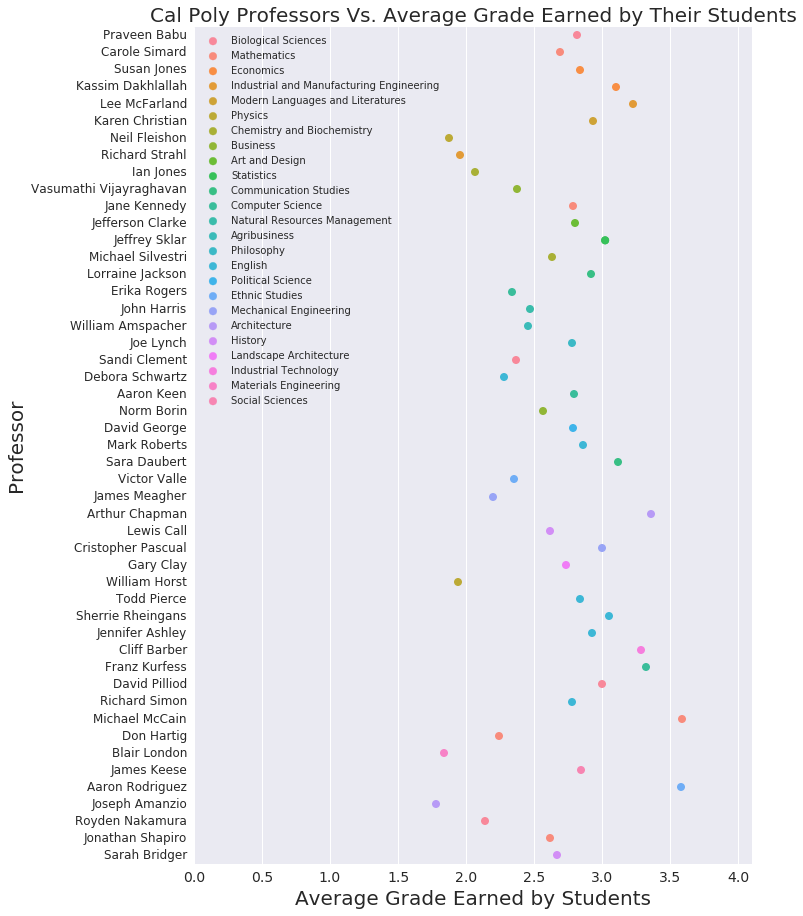

In [29]:
interact(plot_average_grades, n=(0, 70), __manual=True)

The above stripplot of a few random professors shows a trend: 

It looks as though most professors have a habit of passing their students. 

We can see this by the clustering that centers around students' average grades somewhere between 2.5 and 3.0. Let's bootstrap the mean Average Grade Earned by students to be more precise.

# Bootstrap the Mean Average Grade Earned By Students

In [30]:
def calc_avg_avg(size=30):
    '''Calculates the mean of the average grade earned by students of n random professors.
        Args: size (int): number of professors
        Returns: 
            mean of the average grade earned by students
    '''
    
    fifty_professors = average_grades.sample(size, replace=False)
    mean = np.mean(fifty_professors['Average Grade Earned'])
    return mean

In [31]:
def bootstrap_avg_avg(n=50, size=30):
    '''
    Performs a bootstrapping of the mean of the average grade 
    earned by students of n random professors. Resamples n times.
    
    Args: 
        n (int): number of bootstraps
        size (int): number of professors to use when calculating the mean average grade
            per professor.
    Returns: 
        mean (float): the bootstrapped mean of the average grade earned by students.
    
    '''
    means = np.empty(n, dtype=float)
    for i in range(n):
        means[i] = calc_avg_avg(size)
    return means

In [32]:
mean = bootstrap_avg_avg(n=50, size=50)
print('Bootstrapped mean: ', mean.mean())

Bootstrapped mean:  2.69905278673


## The Bootstrapped Mean Average Grade Earned By Students ~ 2.70 on a 4.0 Scale. 
This is a B- average. Good Job Cal Poly :)

----------------------------------------------------------------------------------------

In [33]:
def merge_dfs(df1, df2, key, suffix_1, suffix_2):
    '''
        Merges two dataframes by similar means.
        Args: 
            df1 (pd.DataFrame): First DataFrame object
            df2 (pd.DataFrame): Second DataFrame object
            key (str): name of pd.Series to use as merge key
            suffix_1: suffix to append to duplicate column's name from df1
            suffix_2: suffix to append to duplicate column's name from df2
    
    '''
    
    return pd.merge(df1, df2, how='outer', left_on=key, right_on=key, \
             suffixes=[suffix_1, suffix_2])

In [34]:
merged_courses = merge_dfs(reviews_by_grade, professors, 'prof_id', ' by Grade', ' Total')
merged_courses.dropna(inplace=True)
merged_courses.head()

,Course,Grade,Overall Rating,Presents Material Clearly,Recognizes Student Difficulties,Reporting Evaluations by Grade,Review,Year,prof_id,review_id,Sentiment,Polarity,Subjectivity,Dept,Name,Reporting Evaluations Total
0,CHEM 124,A,3.769,3.769,3.692,13,"To do well in Abel's class, the key is practic...",Freshman,2073,34359,"[0.17954545454545454, 0.5446969696969698]",0.179545,0.544697,Chemistry and Biochemistry,Christina Abel,32
1,CHEM 127,A,3.769,3.769,3.692,13,Great professor! I learned a lot in her class....,Freshman,2073,34176,"[0.4375, 0.6267857142857143]",0.437500,0.626786,Chemistry and Biochemistry,Christina Abel,32
2,CHEM 124,A,3.769,3.769,3.692,13,Dr. Abel is a great chem prof. I would recomme...,Freshman,2073,31660,"[0.3666666666666667, 0.76]",0.366667,0.760000,Chemistry and Biochemistry,Christina Abel,32
3,CHEM 127,A,3.769,3.769,3.692,13,Abel's class is doable but very tedious. Her t...,Sophomore,2073,30100,"[0.006666666666666668, 0.5873611111111111]",0.006667,0.587361,Chemistry and Biochemistry,Christina Abel,32
4,CHEM 125,A,3.769,3.769,3.692,13,She is an excellent professor. She really pre...,Freshman,2073,29539,"[0.4666666666666666, 0.5]",0.466667,0.500000,Chemistry and Biochemistry,Christina Abel,32


In [35]:
assert np.nan not in merged_courses.Course.unique()

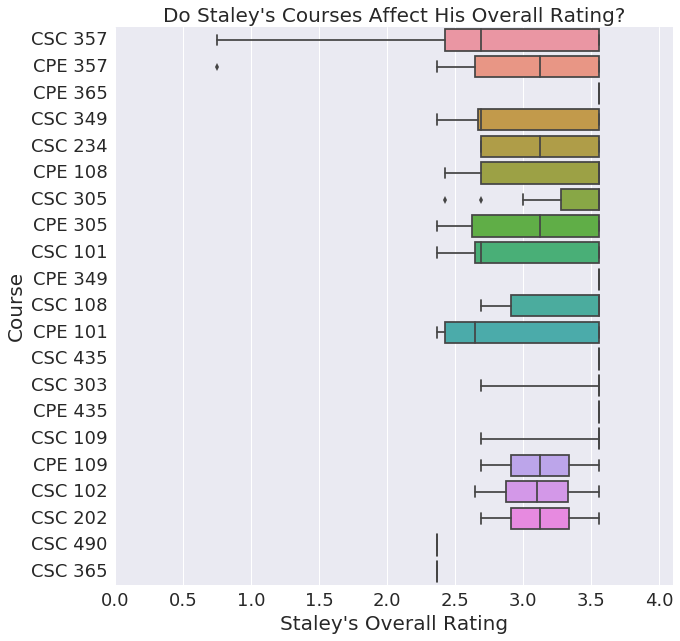

In [36]:
staley = merged_courses.loc[merged_courses['Name'].str.contains('Clint Staley')]

f_5 = plt.figure()
f_5.set_size_inches(10, 10, forward=True)
plt.xlim([0, 4.1])
plt.ylim([0, 4.1])
plt.rcParams.update({'font.size': 20}) 
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

data = staley
sns.boxplot(x=data['Overall Rating'], \
            y=data['Course'], data=data)

y_label = 'Course'
x_label = 'Staley\'s Overall Rating'
title = 'Do Staley\'s Courses Affect His Overall Rating?'
plt.title(title, multialignment='left', fontsize='20') 
plt.xlabel(x_label, fontsize='20')
plt.ylabel(y_label, fontsize='20')

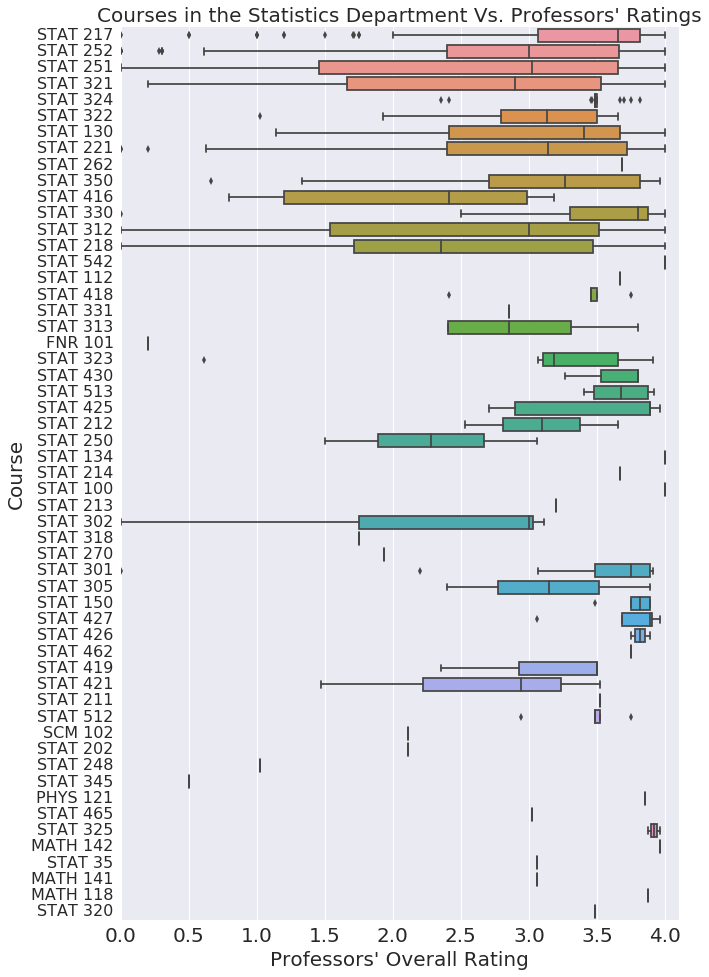

In [37]:
stat_dept = merged_courses.loc[merged_courses['Dept'].str.contains('Statistics')]
f_6 = plt.figure()
f_6.set_size_inches(10, 16, forward=True)
plt.xlim([0, 4.1])
plt.ylim([0, 4.1])
plt.rcParams.update({'font.size': 20}) 
plt.xticks(fontsize=20)
plt.yticks(fontsize=16)

data = stat_dept
sns.boxplot(x=data['Overall Rating'], \
            y=data['Course'], data=data)

y_label = 'Course'
x_label = 'Professors\' Overall Rating'
title = 'Courses in the Statistics Department Vs. Professors\' Ratings'
plt.title(title, multialignment='left', fontsize='20') 
plt.xlabel(x_label, fontsize='20')
plt.ylabel(y_label, fontsize='20')

----------------------------------------------------------------------------------------

# Challenge Area: Beautiful Soup
Below is an example that runs quickly. 
Beautiful Soup allows you to do a lot, including stepping through 'a' tags, or links, on a page.  
This was neat when gathering a list of professors at the very beginning.

In [38]:
professor_list_url = "http://polyratings.com/list.phtml"

def get_professor_urls():
    '''Gets links to professor polyratings pages. 
    
       Returns: 
           professor_paths (list of strings): each is a link.
    '''
    professor_list_url
    index = requests.get(professor_list_url)
    soup = BeautifulSoup(index.text, 'html.parser')
    professor_paths = []
    
    for a in soup.findAll('a'):
        if 'eval' in a['href']:
            professor_paths.append(a['href'])
      
    return professor_paths

In [39]:
'''Get links to all the professors.
   Call parsing methods. 
'''
# Drop the first link to get links only linking to a professor page. 
professor_urls = get_professor_urls()[1:]

In [41]:
professor_urls[0:10]

['http://polyratings.com/eval.phtml?profid=2073',
 'http://polyratings.com/eval.phtml?profid=2390',
 'http://polyratings.com/eval.phtml?profid=2429',
 'http://polyratings.com/eval.phtml?profid=1',
 'http://polyratings.com/eval.phtml?profid=1628',
 'http://polyratings.com/eval.phtml?profid=2',
 'http://polyratings.com/eval.phtml?profid=746',
 'http://polyratings.com/eval.phtml?profid=3',
 'http://polyratings.com/eval.phtml?profid=1252',
 'http://polyratings.com/eval.phtml?profid=2819']

## Above is are 10 samples of professor page urls from the full list.